In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#files = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk('/kaggle/input') for filename in filenames]

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

np.random.seed(31415)

In [2]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, classification_report, accuracy_score, f1_score, plot_confusion_matrix, balanced_accuracy_score
def print_precision_report(y_test,y_pred,x_test,model,labels,unique_classes,plotsize, colormap = False, model_name = ''):
    #getting metrics
    precision = precision_score(y_test, y_pred, average = 'macro')
    recall = recall_score(y_test, y_pred, average = 'macro')
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    
    #ploting confusion matrix
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=plotsize, facecolor = 'white')
    ax.set_title(type(model).__name__)
    disp = plot_confusion_matrix(model, x_test, y_test,display_labels=labels,xticks_rotation=60,ax=ax, normalize='true')
    if not colormap:
        disp.im_.colorbar.remove()
    plt.margins(0.1)
    plt.savefig('{}-10Classes.png'.format(model_name),transparent = False, bbox_inches='tight')
    
    #ROC AUC
    y_test = label_binarize(y_test, classes=unique_classes)
    y_pred = label_binarize(y_pred, classes=unique_classes)
    roc_auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
    
    #printing metrics
    print("Precisão:", precision)
    print("Recall/Revocação/Sensibilidade:", recall)    
    print("Acurácia:", accuracy)
    print("Acurácia Balanceada:",balanced_accuracy)
    print("Medida F1:", f1_score)
    print("Roc AUC:",roc_auc_score)
    
    return [model_name,precision,recall,accuracy,balanced_accuracy,f1,roc_auc]

In [3]:
df_raw = pd.read_csv(f'./processedFiles.csv')
print("Número de linhas e colunas no conjunto de treinamento:", df_raw.shape)
print("Número de linhas e colunas no conjunto de teste:", df_raw.shape)
attributes = list(df_raw.columns)
df_raw.head()

classes_label = {'normal': 0,'imbalance': 1,
                 'overhang cage_fault': 2,'overhang outer_race': 3, 'overhang ball_fault': 4,
                 'underhang cage_fault': 5, 'underhang outer_race': 6, 'underhang ball_fault': 7,
                 'vertical-misalignment':8,
                 'horizontal-misalignment':9}
labes_confusion_matrix = [x.replace('overhang','ov').replace('underhang','un').replace('misalignment','mis') for x in classes_label.keys()]

colors = ['blue','red','green','limegreen','darkgreen','magenta','darkmagenta','violet','orange','cyan']

df_X = df_raw.drop(['Unnamed: 0','filePath','Class6','Class10'],axis = 1)
df_raw['Class10'] = df_raw[['Class6','Class10']].apply(lambda x: x[0] if x[0] == x[1] else ' '.join(x), axis=1)

scaler = StandardScaler().fit(df_X)
X = scaler.transform(df_X)
Y = df_raw['Class10'].map(classes_label).to_numpy()
unique_classes = np.unique(Y)

df_X.head(10)

Número de linhas e colunas no conjunto de treinamento: (1951, 85)
Número de linhas e colunas no conjunto de teste: (1951, 85)


,Tachometer main frequency,Tachometer mean,Tachometer entropy,Tachometer kurtosis,Tachometer rms,Tachometer peak to peak,Tachometer shape indicator,Tachometer impulse indicator,Tachometer crest indicator,Tachometer clearance indicator,...,Microphone mean,Microphone entropy,Microphone kurtosis,Microphone rms,Microphone peak to peak,Microphone shape indicator,Microphone impulse indicator,Microphone crest indicator,Microphone clearance indicator,Microphone skewness
0,12.0,0.002930,2.155789,4.304473,1.585572,-6.2337,1.617277,5.209933,3.221424,6.496703,...,0.008016,1.818507,0.065309,0.112425,-0.77416,1.221686,5.872358,4.806766,6.752480,0.685550
1,12.8,0.005695,2.153490,4.168970,1.596103,-6.2125,1.609710,5.110197,3.174607,6.361800,...,0.007704,1.834837,0.241943,0.116036,-0.86253,1.228879,6.391702,5.201244,7.374075,0.740827
2,14.0,-0.003637,2.150613,4.138177,1.598855,-6.2670,1.595314,5.081820,3.185467,6.290660,...,0.017536,1.910258,0.063221,0.132987,-0.96741,1.236221,6.284034,5.083263,7.279235,0.694690
3,14.8,0.002550,2.149442,3.967702,1.612556,-6.3006,1.589255,5.000190,3.146247,6.185735,...,0.019339,1.919532,0.018246,0.135144,-0.96375,1.235200,6.260704,5.068577,7.249635,0.674586
4,15.8,0.004700,2.162512,3.813742,1.625237,-6.3730,1.579440,4.958330,3.139296,6.121404,...,0.014026,1.880101,-0.100899,0.125709,-0.83014,1.218678,5.577019,4.576287,6.405791,0.616928
5,16.8,-0.002639,2.163104,3.819209,1.624728,-6.4590,1.571273,4.906867,3.122861,6.037446,...,0.011380,1.874983,0.043660,0.124522,-0.87701,1.223577,6.005457,4.908114,6.914232,0.664931
6,18.0,-0.002509,2.152143,3.734698,1.631818,-6.3477,1.564022,4.843449,3.096791,5.945002,...,0.013102,1.885812,0.150725,0.127139,-0.91561,1.231728,6.152573,4.995076,7.109552,0.698158
7,19.2,0.000546,2.150201,3.595487,1.643699,-6.3302,1.555974,4.775935,3.069419,5.851070,...,0.013488,1.930206,0.135242,0.136813,-0.97410,1.231472,6.085748,4.941850,7.036395,0.696739
8,19.8,-0.000553,2.149882,3.570277,1.645932,-6.2874,1.552674,4.777075,3.076677,5.846183,...,0.013546,1.935647,0.180273,0.138068,-0.99201,1.233676,6.020773,4.880351,6.968443,0.708950
9,21.2,0.001392,2.151135,3.433023,1.658026,-6.3496,1.543289,4.693555,3.041268,5.730218,...,0.011827,1.929733,0.108563,0.136460,-0.94545,1.228972,5.832187,4.745583,6.736015,0.684121


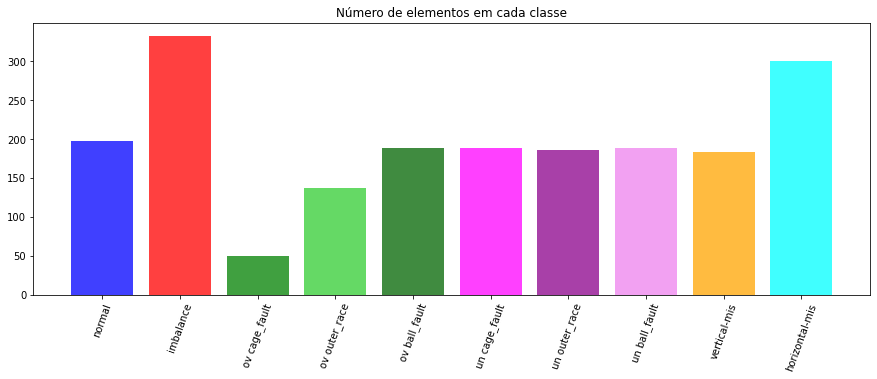

In [4]:
classes = df_raw['Class10']
cl = np.unique(classes)
ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = classes == cl[i]
    ncl[i] = len(classes[a])
    
numbers = np.arange(0, len(cl))
plt.figure(figsize=(15,5))
plt.bar(numbers, ncl,  alpha=.75,color = colors)
plt.xticks(numbers, labes_confusion_matrix, rotation = 70)
plt.title('Número de elementos em cada classe')
plt.show(True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [5]:
param_grid = {'n_estimators': range(1,50,2),
             'class_weight': ['balanced'] }
base_estimator = RandomForestClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_RF.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_RF.best_score_)

model = grid_RF.best_estimator_
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   37.7s finished


Melhor modelo: {'class_weight': 'balanced', 'n_estimators': 45}
Melhor acurácia: 0.9695972686733556


Precisão: 0.9797826199774994
Recall/Revocação/Sensibilidade: 0.9603182168772777
Acurácia: 0.9761092150170648
Acurácia Balanceada: 0.9603182168772777
Medida F1: <function f1_score at 0x0000021F42116EE0>
Roc AUC: <function roc_auc_score at 0x0000021F421134C0>


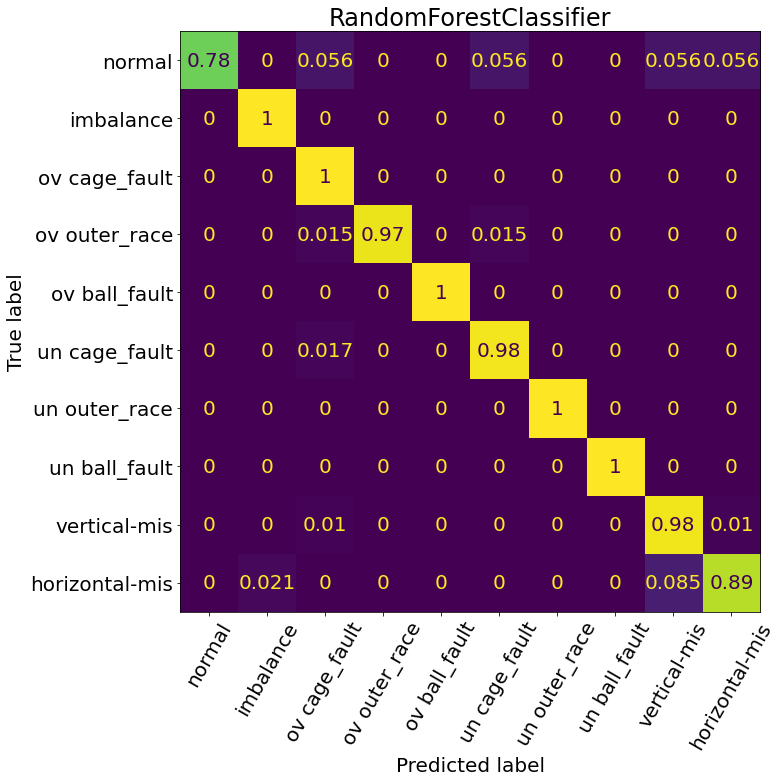

In [7]:
RandomForestMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'Random Forest')

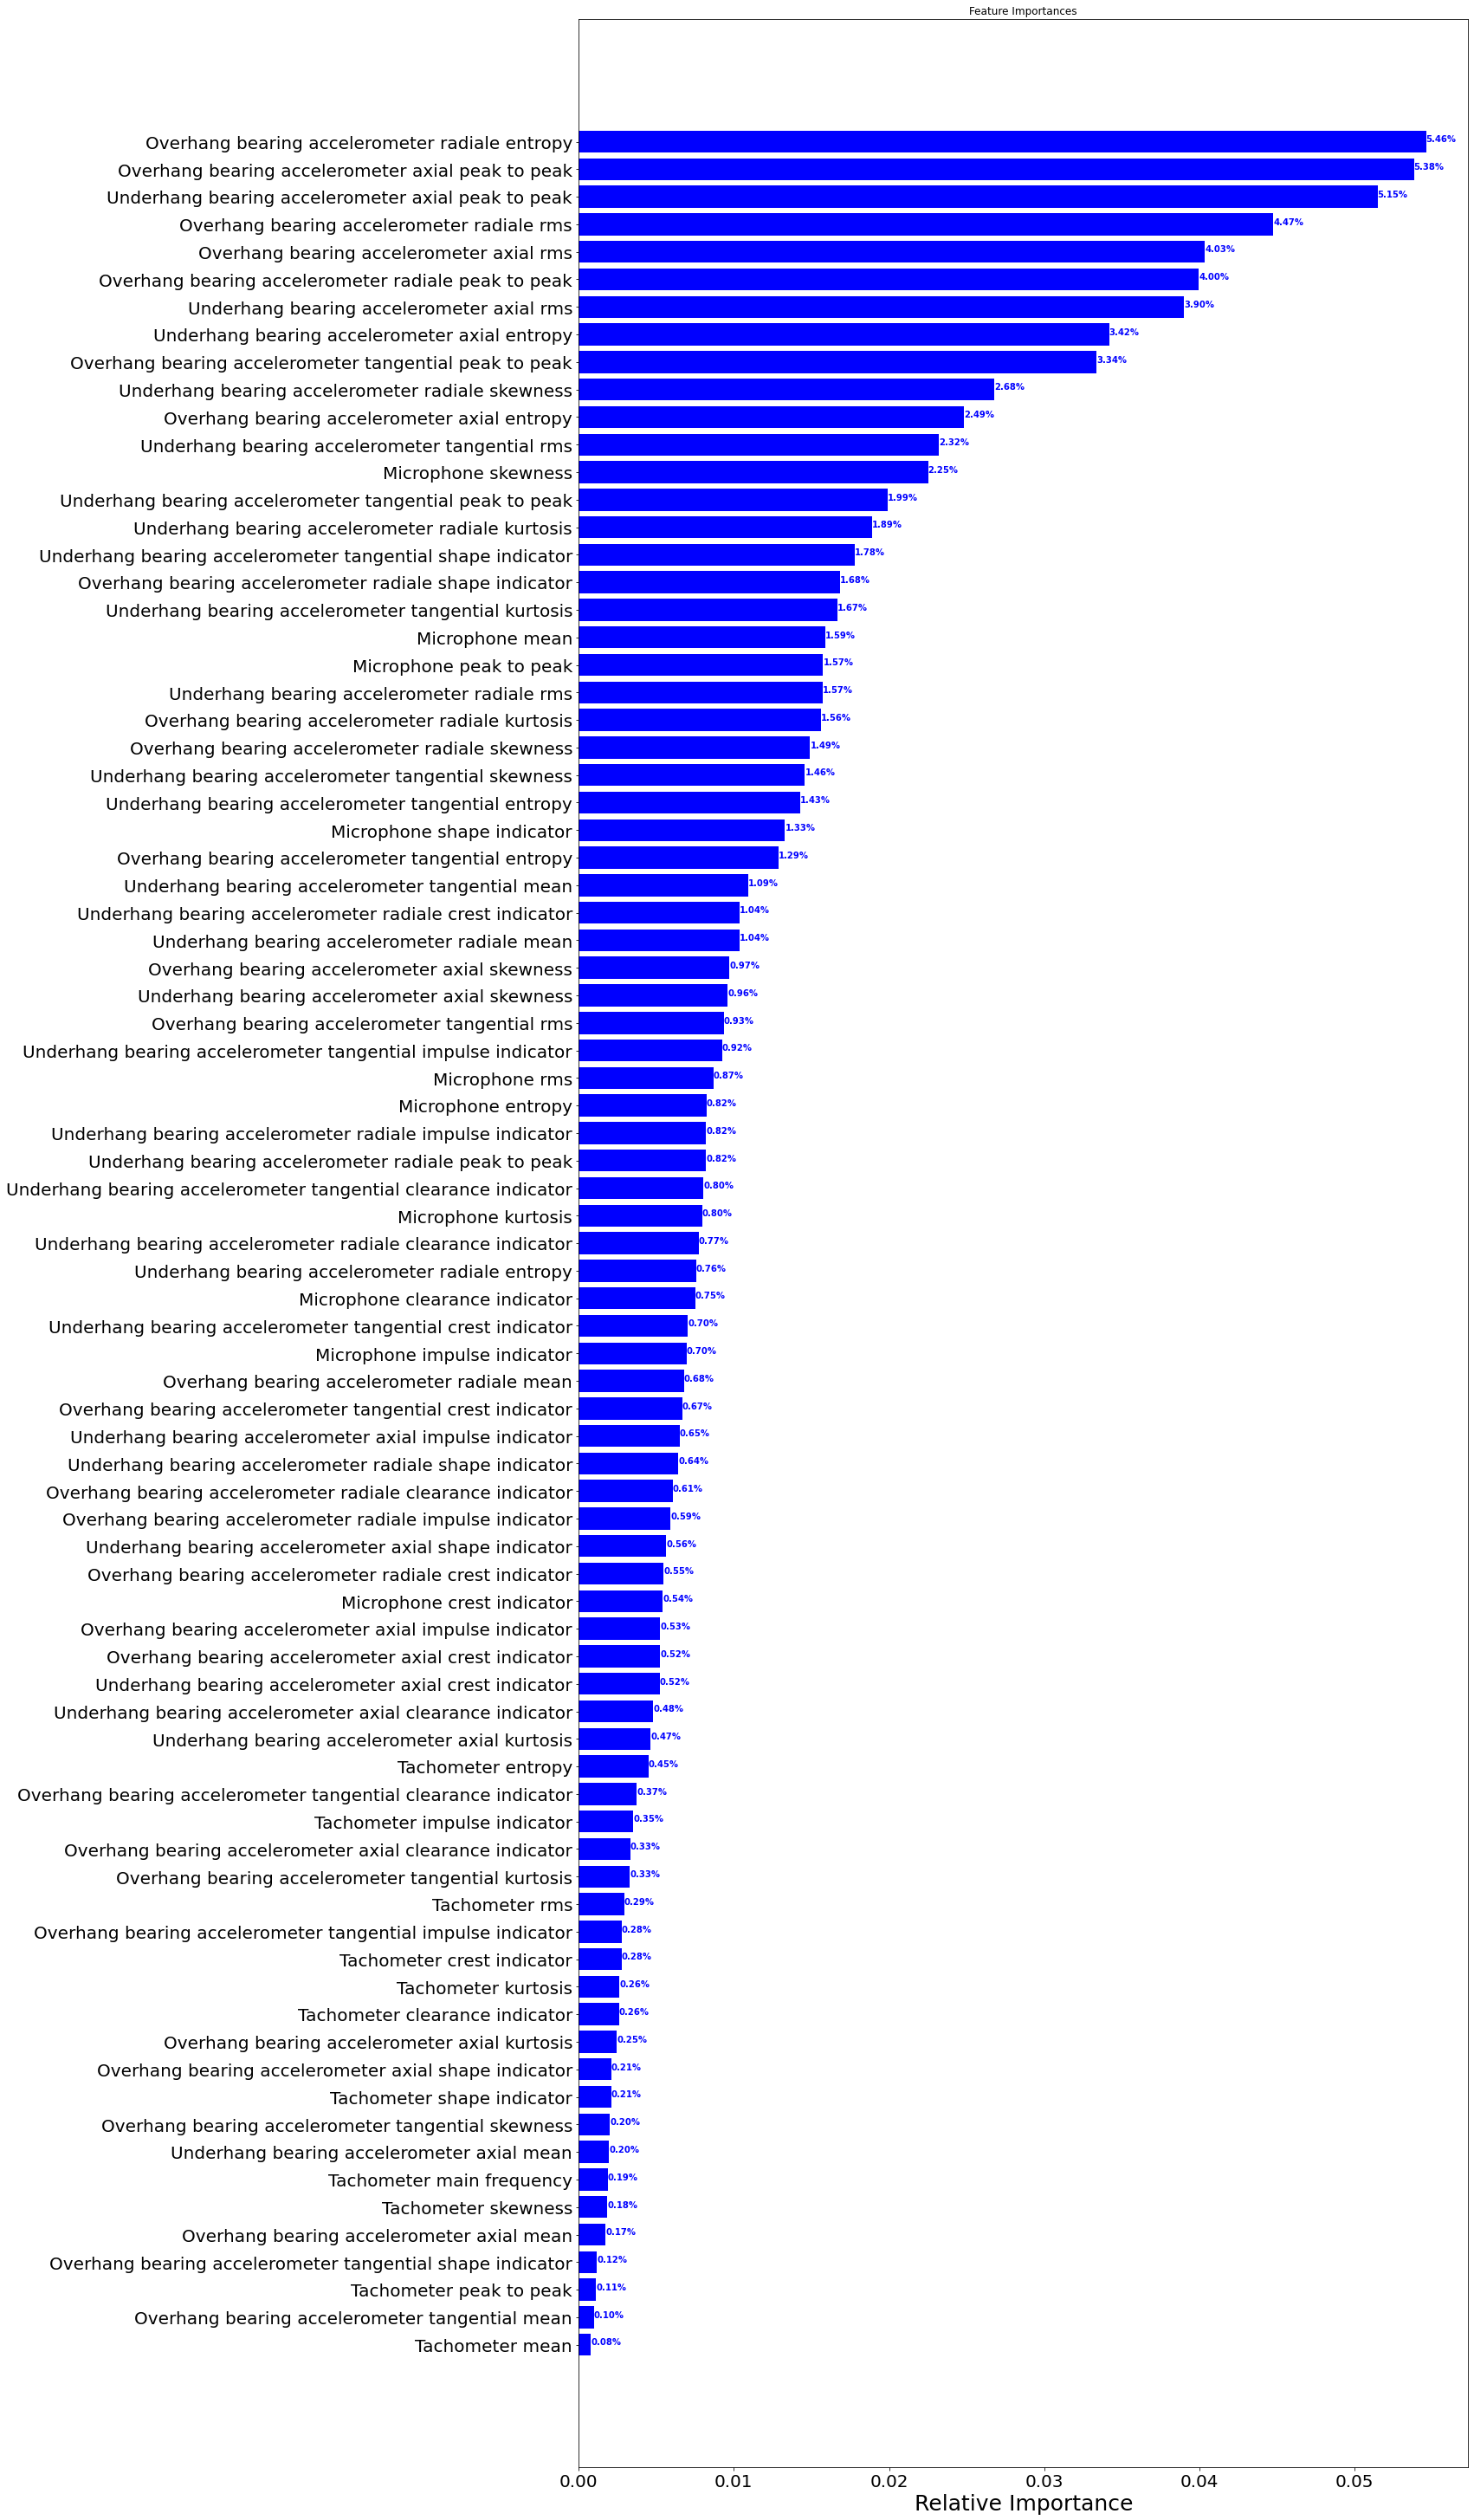

In [6]:
importances = model.feature_importances_
attributes = df_X.columns
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
fig, ax = plt.subplots(figsize=(15,40))
plt.title('Feature Importances')
plt.tight_layout()
ax.barh(range(len(indices)), importances[indices], color='b', align='center')

for i, v in enumerate(importances[indices]):
    ax.text(v , i , '{:.2f}%'.format(v*100), color='blue', fontweight='bold')

plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

In [8]:
importances = model.feature_importances_
importances = pd.DataFrame(importances.T)
importances = importances.T
importances.columns = df_X[1:].columns

sensors = {'Tachometer':np.array([0]),'Underhang bearing accelerometer axial':np.array([0]),'Underhang bearing accelerometer radiale':np.array([0]),
           'Underhang bearing accelerometer tangential':np.array([0]),'Overhang bearing accelerometer axial':np.array([0]),
           'Overhang bearing accelerometer radiale':np.array([0]),'Overhang bearing accelerometer tangential':np.array([0]),'Microphone':np.array([0])}
for sensor in sensors.keys():
    for column in importances.columns[1:]:
        if column.startswith(sensor):
            sensors[sensor] = np.concatenate((sensors[sensor],importances[column].values), axis=None)
sensors = pd.DataFrame(sensors)
sensors.columns = sensors.keys()
sensors.drop([0],inplace = True)
sensors.head()

,Tachometer,Underhang bearing accelerometer axial,Underhang bearing accelerometer radiale,Underhang bearing accelerometer tangential,Overhang bearing accelerometer axial,Overhang bearing accelerometer radiale,Overhang bearing accelerometer tangential,Microphone
1,0.000780,0.001971,0.010352,0.010931,0.001741,0.006798,0.000976,0.015878
2,0.004493,0.034183,0.007566,0.014274,0.024852,0.054594,0.012858,0.008228
3,0.002641,0.004653,0.018910,0.016689,0.002451,0.015621,0.003301,0.007950
4,0.002937,0.039013,0.015734,0.023223,0.040346,0.044747,0.009347,0.008680
5,0.001113,0.051471,0.008199,0.019906,0.053820,0.039959,0.033367,0.015748


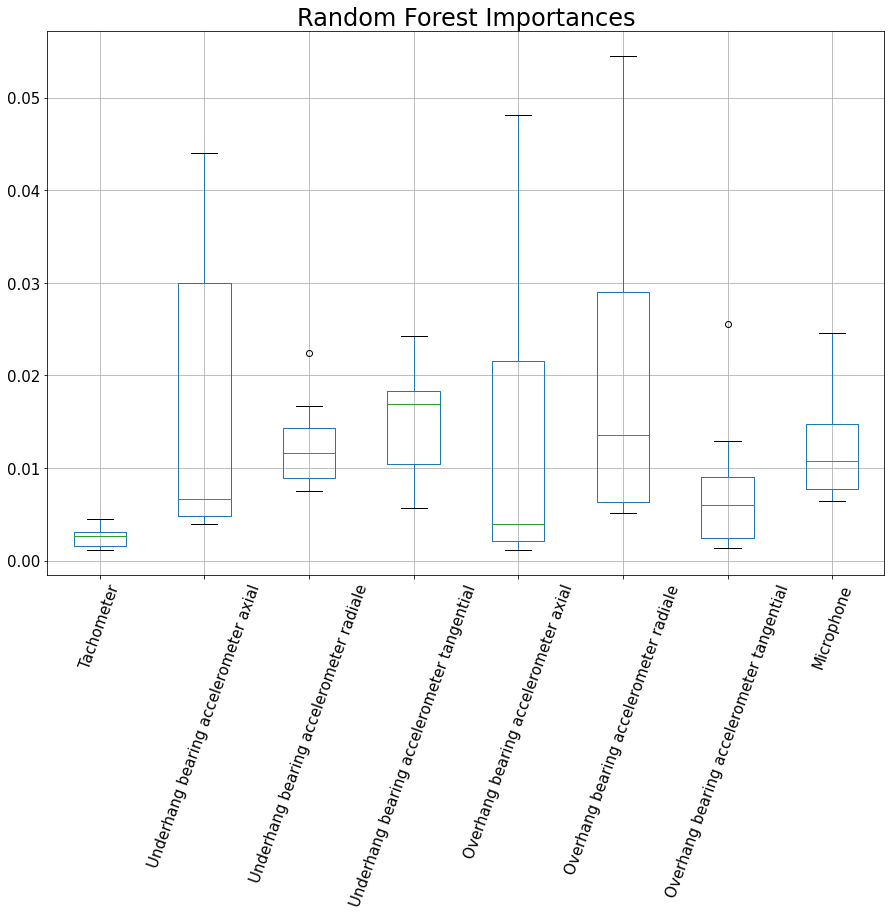

In [37]:
axs = sensors.boxplot(figsize=(15,10),rot=70, fontsize=15,return_type = 'axes')
axs.set_title('Random Forest Importances')
plt.savefig('RandomForestImportances.png',transparent = False, bbox_inches='tight')

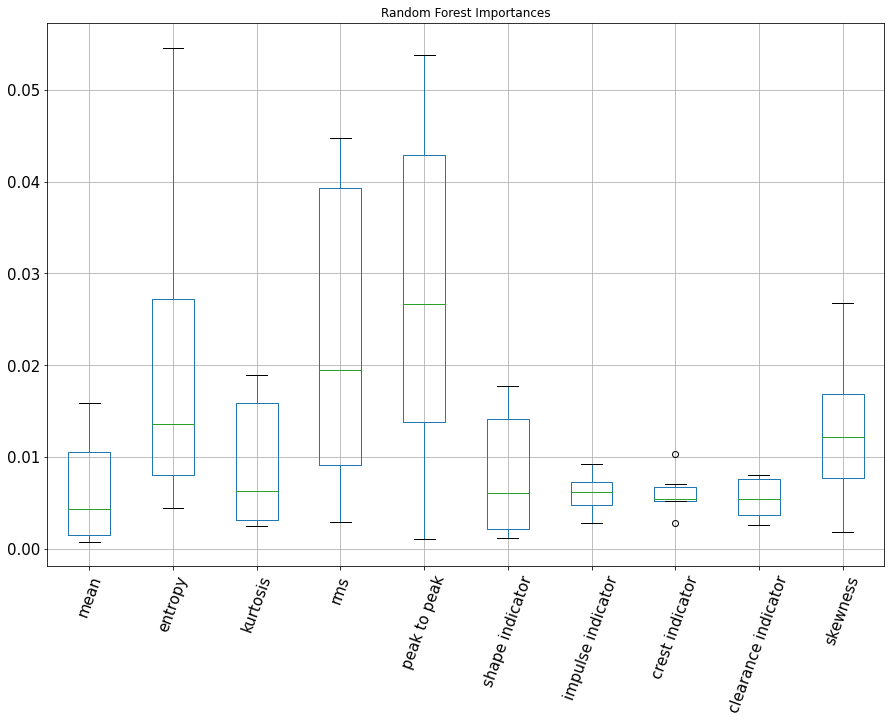

In [10]:
features = {'mean':np.array([0]),'entropy':np.array([0]),'kurtosis':np.array([0]),'rms':np.array([0]),'peak to peak':np.array([0]),
           'shape indicator':np.array([0]),'impulse indicator':np.array([0]),'crest indicator':np.array([0]),
           'clearance indicator':np.array([0]),'skewness':np.array([0])}
for feature in features.keys():
    for column in importances.columns[1:]:
        if column.endswith(feature):
            features[feature] = np.concatenate((features[feature],importances[column].values), axis=None)
features = pd.DataFrame(features)
features.columns = features.keys()
features.drop([0],inplace = True)
axs = features.boxplot(figsize=(15,10),rot=70, fontsize=15,return_type='axes')
axs.set_title('Random Forest Importances')
plt.savefig('RandomForestImportances_Features.png',transparent = False, bbox_inches='tight')

In [9]:
%%time
param_grid = {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
base_estimator = SVC(gamma='scale')
grid_SVC = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_SVC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_SVC.best_score_)
model = grid_SVC.best_estimator_
y_pred = model.predict(x_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Melhor modelo: {'C': 100, 'kernel': 'rbf'}
Melhor acurácia: 0.9664555263577004
Wall time: 12.4 s


Precisão: 0.965008042697592
Recall/Revocação/Sensibilidade: 0.9589339013416556
Acurácia: 0.962457337883959
Acurácia Balanceada: 0.9589339013416556
Medida F1: <function f1_score at 0x00000141C45BD790>
Roc AUC: <function roc_auc_score at 0x00000141C45ADA60>


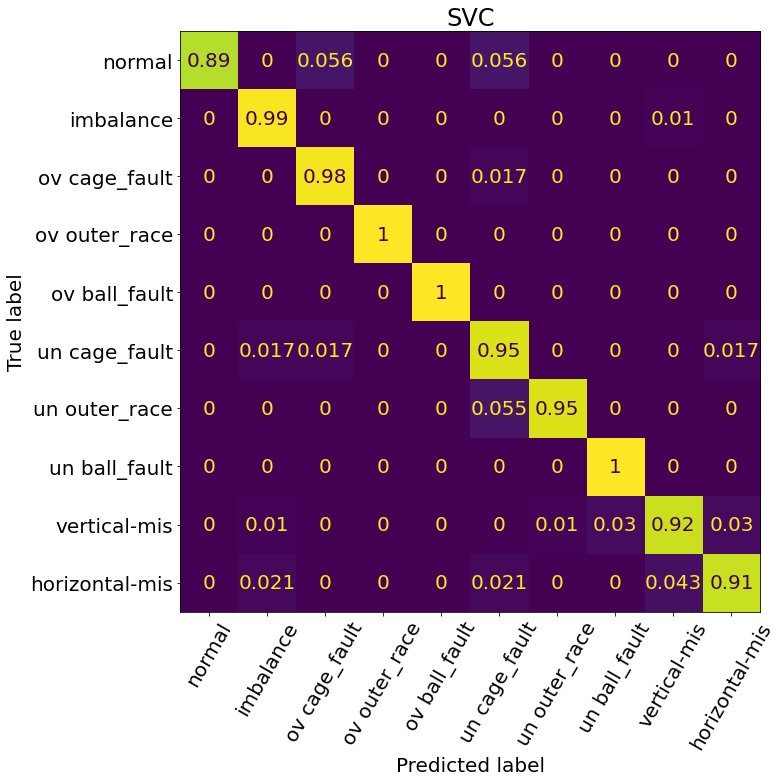

In [10]:
SVCMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'SVM')

In [11]:
%%time
from sklearn.neural_network import MLPClassifier

param_grid = {'solver': ['lbfgs'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'max_iter': [1000, 1200, 1400], 
              'alpha': 10.0 ** -np.arange(1, 3), 
              'hidden_layer_sizes': [(10,10),(10,30),
                                     (20,10),(20,30),
                                     (30,10),(30,30)]}
base_estimator = MLPClassifier()
grid_MLPC = GridSearchCV(base_estimator, param_grid, cv = 10, scoring = 'balanced_accuracy', verbose = 2, n_jobs=-1,).fit(x_train, y_train)

# Return set of parameters with the best performances
print('Melhor modelo:', grid_MLPC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_MLPC.best_score_)
model = grid_MLPC.best_estimator_
y_pred = model.predict(x_test)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Melhor modelo: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (30, 10), 'max_iter': 1200, 'solver': 'lbfgs'}
Melhor acurácia: 0.9797289377289378
Wall time: 8min 56s


Precisão: 0.9773872460593644
Recall/Revocação/Sensibilidade: 0.971868588163829
Acurácia: 0.9726962457337884
Acurácia Balanceada: 0.971868588163829
Medida F1: <function f1_score at 0x00000141C45BD790>
Roc AUC: <function roc_auc_score at 0x00000141C45ADA60>


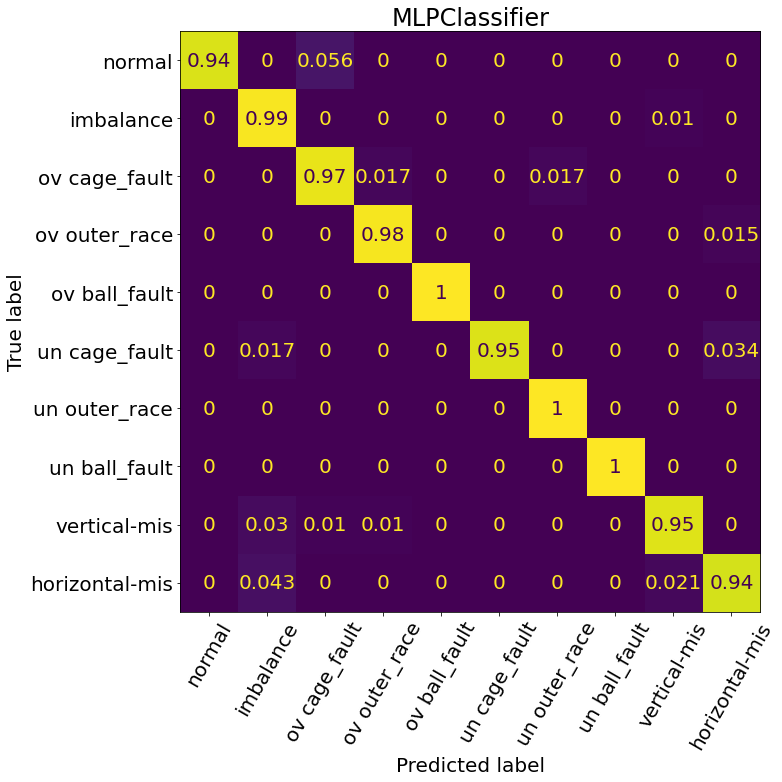

In [12]:
MLPMetrics = print_precision_report(y_test,y_pred,x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'MLP')

In [13]:
results = pd.DataFrame([RandomForestMetrics,SVCMetrics,MLPMetrics], columns=['Modelo','Precisao','Recall','Acuracia','acuraciaBalanceada','FScore','ROCAUC']) 
results.set_index('Modelo', inplace = True)
results = results * 100
results.to_csv('10classesResults.csv',float_format='%.2f')
results.head()

,Precisao,Recall,Acuracia,acuraciaBalanceada,FScore,ROCAUC
Modelo,,,,,,
Random Forest,97.683277,95.718046,97.269625,95.718046,96.527399,97.702421
SVM,96.500804,95.893390,96.245734,95.893390,96.140307,97.734718
MLP,97.738725,97.186859,97.269625,97.186859,97.438116,98.436256


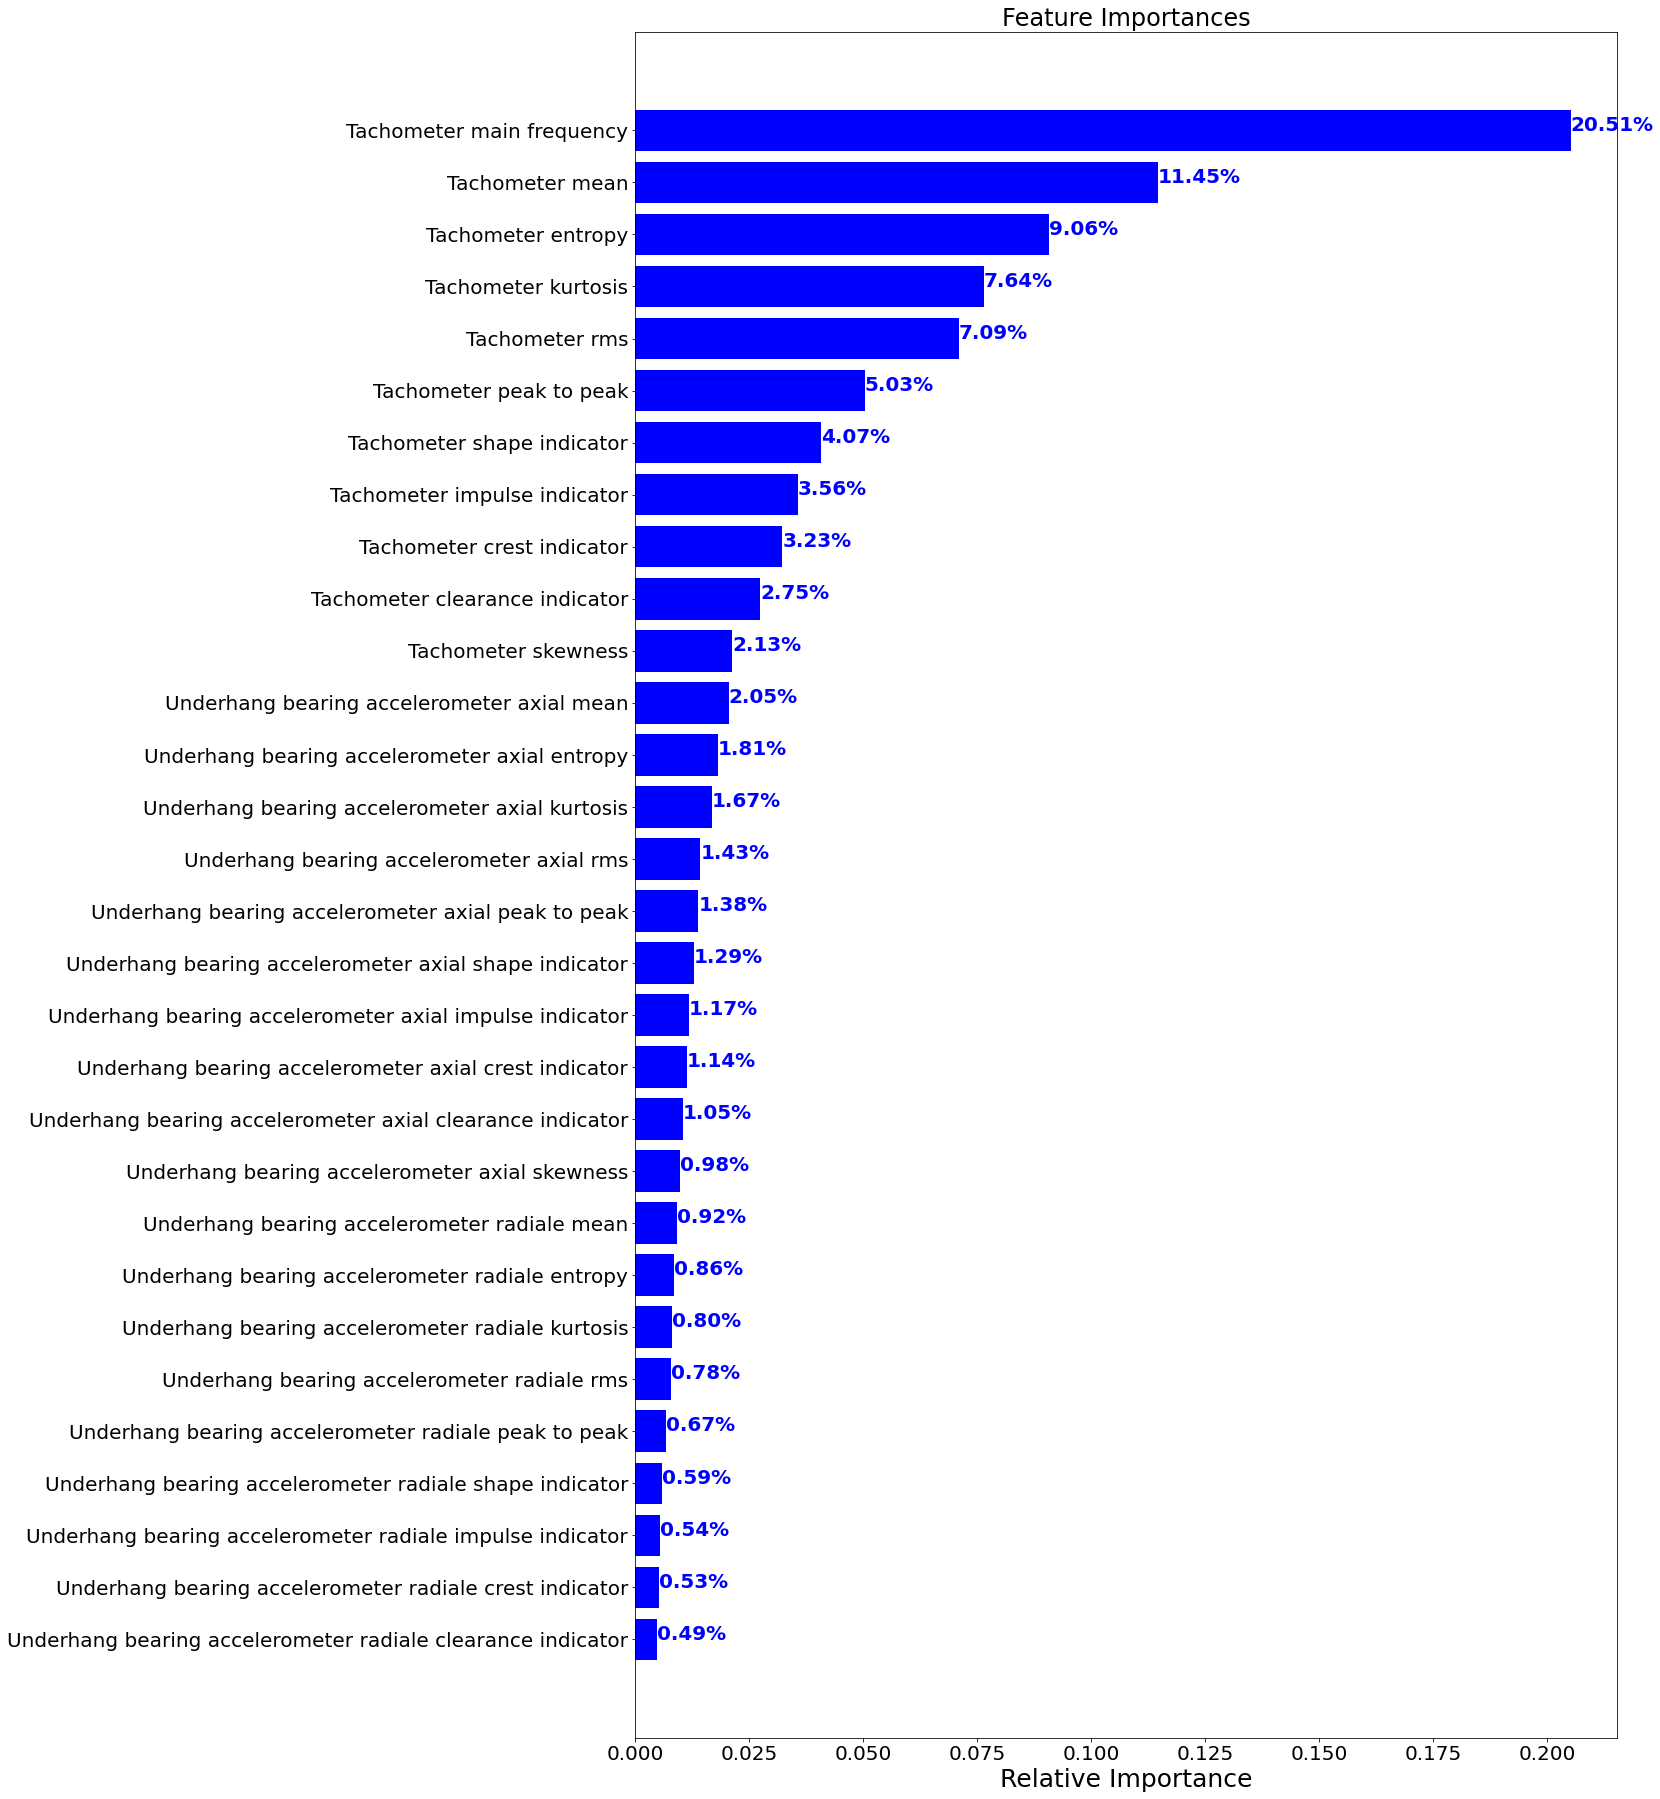

In [14]:
pca = PCA(n_components = 30)
pca_result = pca.fit_transform(X)
var_exp = pca.explained_variance_ratio_

importances = var_exp
attributes = df_X.columns
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
fig, ax = plt.subplots(figsize=(15,25))
plt.title('Feature Importances')
plt.tight_layout()
ax.barh(range(len(indices)), importances[indices], color='b', align='center')

for i, v in enumerate(importances[indices]):
    ax.text(v , i , '{:.2f}%'.format(v*100), color='blue', fontweight='bold')

plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

In [15]:
pca_result_x_train, pca_result_x_test, y_train, y_test = train_test_split(pca_result, Y, test_size = 0.3)

In [16]:
%%time
param_grid = {'n_estimators': range(1,50,2),
             'class_weight': ['balanced'] }
base_estimator = RandomForestClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_RF.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_RF.best_score_)

model = grid_RF.best_estimator_
model.fit(pca_result_x_train, y_train)
y_pred = model.predict(pca_result_x_test) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Melhor modelo: {'class_weight': 'balanced', 'n_estimators': 25}
Melhor acurácia: 0.8450968669012147
Wall time: 18.1 s


Precisão: 0.8720760456029526
Recall/Revocação/Sensibilidade: 0.8278908769553748
Acurácia: 0.8600682593856656
Acurácia Balanceada: 0.8278908769553748
Medida F1: <function f1_score at 0x00000141C45BD790>
Roc AUC: <function roc_auc_score at 0x00000141C45ADA60>


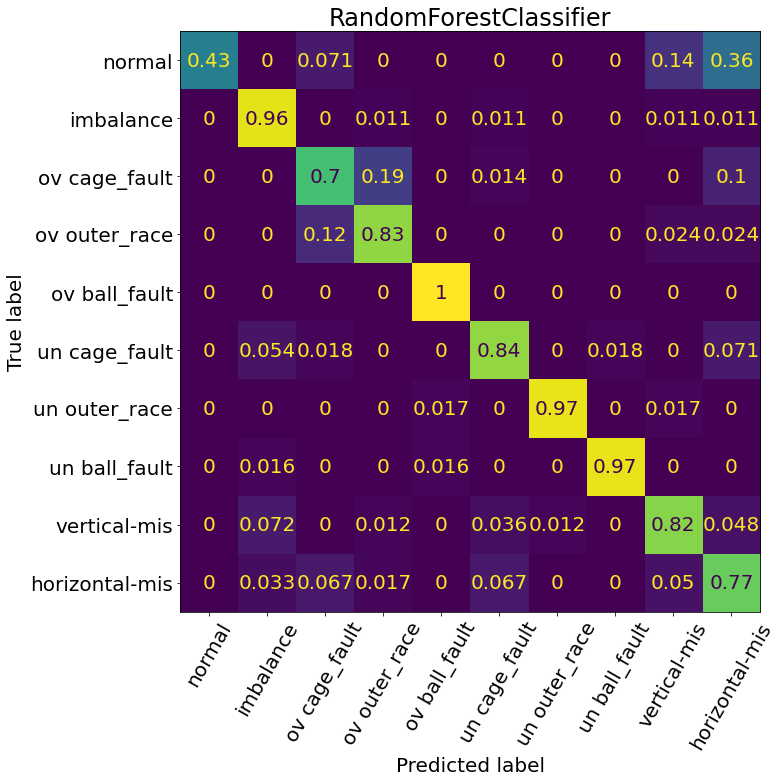

In [17]:
RandomForestMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'Random Forest - PCA')

In [18]:
%%time
param_grid = {'C': [1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
base_estimator = SVC(gamma='scale')
grid_SVC = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_SVC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_SVC.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor modelo: {'C': 100, 'kernel': 'rbf'}
Melhor acurácia: 0.9585484841245713
Wall time: 3.26 s


Precisão: 0.9606316513492186
Recall/Revocação/Sensibilidade: 0.9460913327495444
Acurácia: 0.9573378839590444
Acurácia Balanceada: 0.9460913327495444
Medida F1: <function f1_score at 0x00000141C45BD790>
Roc AUC: <function roc_auc_score at 0x00000141C45ADA60>


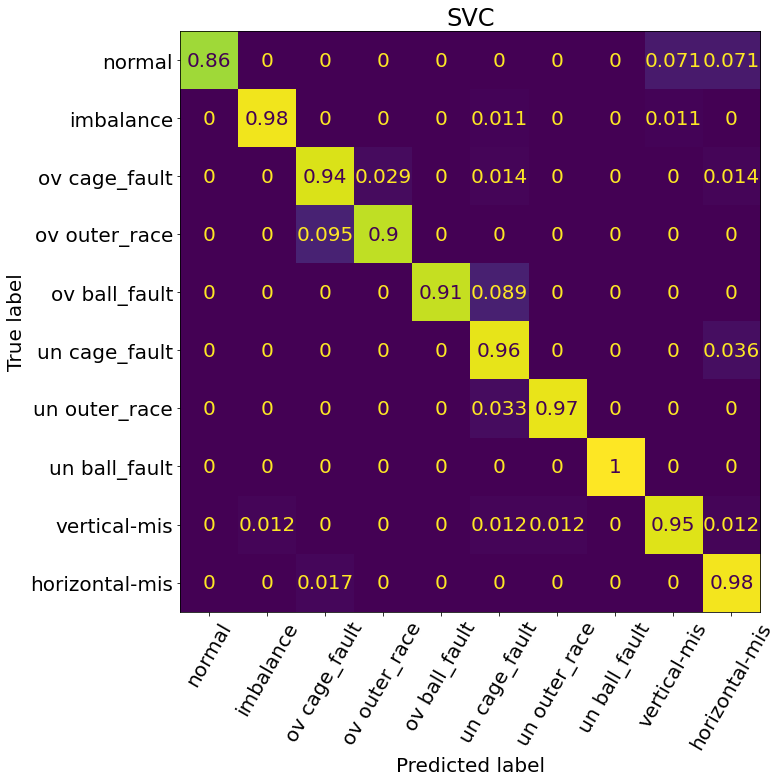

In [19]:
model = grid_SVC.best_estimator_
y_pred = model.predict(pca_result_x_test)
SVCMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'SVC - PCA')

In [20]:
%%time
param_grid = {'solver': ['lbfgs'],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'max_iter': [1000, 1200, 1400],
              'alpha': 10.0 ** -np.arange(1, 3),
              'hidden_layer_sizes': [(10,10),(10,30),
                                     (20,10),(20,30),
                                     (30,10),(30,30)]}
base_estimator = MLPClassifier()
grid_RF = GridSearchCV(base_estimator, param_grid, cv=10, scoring = 'balanced_accuracy', verbose = 2, n_jobs=-1).fit(pca_result_x_train, y_train)
# Return set of parameters with the best performances
print('Melhor modelo:', grid_MLPC.best_params_)
# Return the performance metric score
print('Melhor acurácia:', grid_MLPC.best_score_)

model = grid_MLPC.best_estimator_
model.fit(pca_result_x_train,y_train)
y_pred = model.predict(pca_result_x_test)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Melhor modelo: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (30, 10), 'max_iter': 1200, 'solver': 'lbfgs'}
Melhor acurácia: 0.9797289377289378
Wall time: 17min 10s


Precisão: 0.9664796292417261
Recall/Revocação/Sensibilidade: 0.9693849835431951
Acurácia: 0.9709897610921502
Acurácia Balanceada: 0.9693849835431951
Medida F1: <function f1_score at 0x00000141C45BD790>
Roc AUC: <function roc_auc_score at 0x00000141C45ADA60>


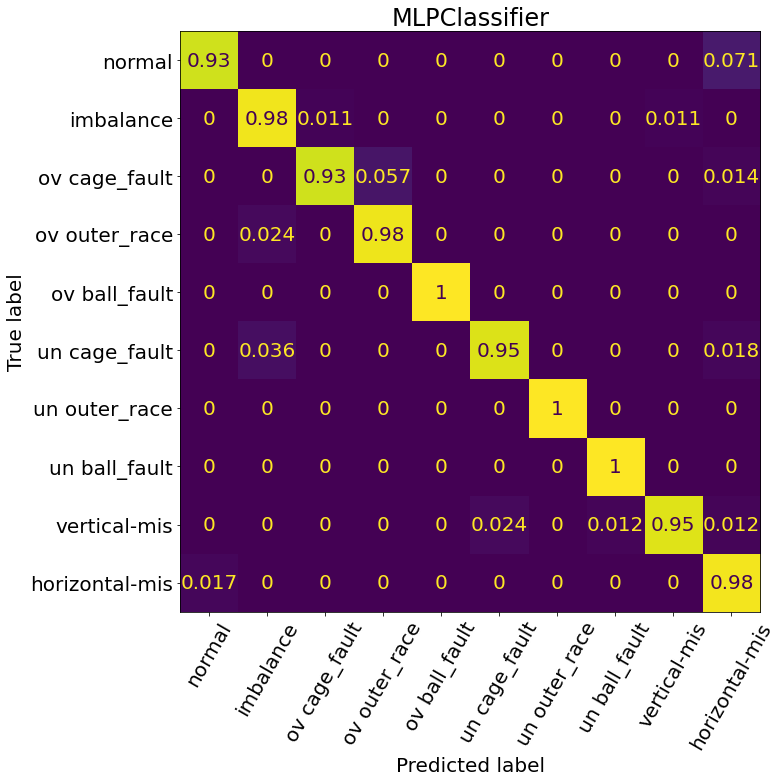

In [21]:
MLPMetrics = print_precision_report(y_test,y_pred,pca_result_x_test,model,
                       labels = labes_confusion_matrix, 
                       unique_classes = unique_classes,
                       plotsize = (13,13), colormap = False, model_name = 'MLP - PCA')

In [22]:
results = pd.DataFrame([RandomForestMetrics,SVCMetrics,MLPMetrics], columns=['Modelo','Precisao','Recall','Acuracia','acuraciaBalanceada','FScore','ROCAUC']) 
results.set_index('Modelo', inplace = True)
results = results * 100
results.to_csv('10classesPCAResults.csv',float_format='%.2f')
results.head()

,Precisao,Recall,Acuracia,acuraciaBalanceada,FScore,ROCAUC
Modelo,,,,,,
Random Forest - PCA,87.207605,82.789088,86.006826,82.789088,83.673653,90.607628
SVC - PCA,96.063165,94.609133,95.733788,94.609133,95.210722,97.065731
MLP - PCA,96.647963,96.938498,97.098976,96.938498,96.763041,98.307148
